## Import some packages

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import integrate
import sys
import os
sys.path.append("../../../../")
from ADFWI.propagator  import *
from ADFWI.model       import *
from ADFWI.view        import *
from ADFWI.utils       import *
from ADFWI.survey      import *

project_path = "./examples/dip/02_Unet/data"
if not os.path.exists(os.path.join(project_path,"model")):
    os.makedirs(os.path.join(project_path,"model"))
if not os.path.exists(os.path.join(project_path,"waveform")):
    os.makedirs(os.path.join(project_path,"waveform"))
if not os.path.exists(os.path.join(project_path,"survey")):
    os.makedirs(os.path.join(project_path,"survey"))

## Basic Parameter

In [2]:
device = "cuda:0"         # Specify the GPU device
dtype = torch.float32     # Set data type to 32-bit floating point
ox, oz = 0, 0             # Origin coordinates for x and z directions
nz, nx = 88, 200          # Grid dimensions in z and x directions
dx, dz = 40, 40           # Grid spacing in x and z directions
nt, dt = 1600, 0.003      # Time steps and time interval
nabc = 30                 # Thickness of the absorbing boundary layer
f0 = 5                    # Initial frequency in Hz
free_surface = True       # Enable free surface boundary condition


## Define the True Velocity Model

In [3]:
# Load the Marmousi model dataset
marmousi_model = load_marmousi_model(in_dir="./examples/datasets/marmousi2_source")

# Resample the Marmousi model for the defined coordinates
x = np.linspace(5000, 5000 + dx * nx, nx)
z = np.linspace(0, dz * nz, nz)
vel_model = resample_marmousi_model(x, z, marmousi_model)

# Extract and transpose the primary wave velocity (vp)
vp = vel_model['vp'].T

# Calculate density (rho) based on velocity
rho = np.power(vp, 0.25) * 310

# Initialize the AcousticModel with parameters and properties
model = AcousticModel(ox, oz, nx, nz, dx, dz,
                      vp, rho,
                      vp_grad=False,
                      free_surface=free_surface,
                      abc_type="PML",
                      abc_jerjan_alpha=0.007,
                      nabc=nabc,
                      device=device,
                      dtype=dtype)

# Save the model to a file
model.save(os.path.join(project_path, "model/true_model.npz"))

# Print the model representation
print(model.__repr__())

model with parameters ['vp', 'rho']:
  Model vp  :  1500.00 -  4777.70 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  1929.23 -  2577.31 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =  40.00, dz =  40.00 m
  Model dims: nx =    200, nz =     88
  Model size: 35200
  Free surface: True
  Absorbing layers: 30



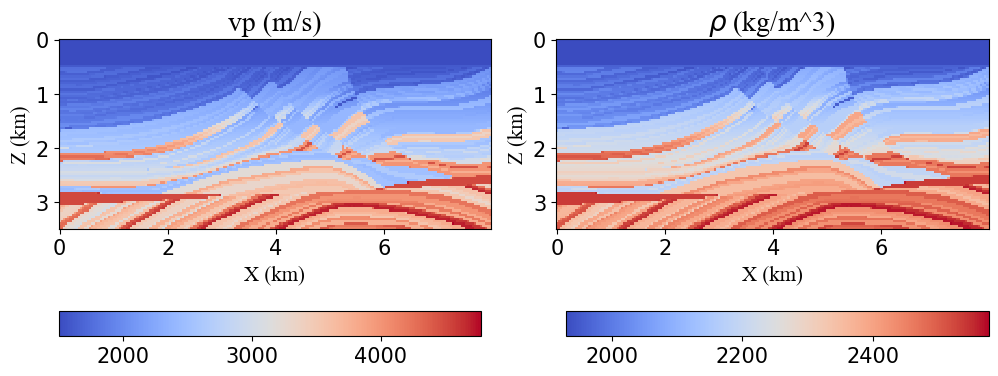

In [4]:
# Plot the primary wave velocity (vp) and density (rho) of the model
model._plot_vp_rho(figsize=(12,5),wspace=0.15,cbar_pad_fraction=0.02,cmap='coolwarm',save_path=os.path.join(project_path,"model/true_vp_rho.png"))

## Define the observed System： Survey = Source + Receiver

In [5]:
# Define source positions in the model
src_z = np.array([1 for i in range(2, nx-1, 5)])  # Z-coordinates for sources
src_x = np.array([i for i in range(2, nx-1, 5)])  # X-coordinates for sources

# Generate wavelet for the source
src_t, src_v = wavelet(nt, dt, f0, amp0=1)  # Create time and wavelet amplitude
src_v = integrate.cumtrapz(src_v, axis=-1, initial=0)  # Integrate wavelet to get velocity

source = Source(nt=nt, dt=dt, f0=f0)  # Initialize source object

# Method 1: Add multiple sources at once (commented out)
# source.add_sources(src_x=src_x, src_z=src_z, src_wavelet=src_v, src_type='mt', src_mt=np.array([[1,0,0],[0,1,0],[0,0,1]]))

# Method 2: Loop through each source position to add them individually
for i in range(len(src_x)):
    source.add_source(src_x=src_x[i], src_z=src_z[i], src_wavelet=src_v, src_type="mt", src_mt=np.array([[1,0,0],[0,1,0],[0,0,1]]))


In [6]:
# Define receiver positions in the model
rcv_z = np.array([1 for i in range(0, nx, 1)])  # Z-coordinates for receivers
rcv_x = np.array([j for j in range(0, nx, 1)])  # X-coordinates for receivers

receiver = Receiver(nt=nt, dt=dt)  # Initialize receiver object

# Method 1: Add all receivers at once (commented out)
# receiver.add_receivers(rcv_x=rcv_x, rcv_z=rcv_z, rcv_type='pr')

# Method 2: Loop through each receiver position to add them individually
for i in range(len(rcv_x)):
    receiver.add_receiver(rcv_x=rcv_x[i], rcv_z=rcv_z[i], rcv_type="pr")

In [7]:
# Create a survey object using the defined source and receiver
survey = Survey(source=source, receiver=receiver)

# Print a representation of the survey object to check its configuration
print(survey.__repr__())

Survey Information:
Seismic Source:
  Source wavelet: 1600 samples at 3.00 ms
  Source number : 40
  Source types  : ['mt']
  Source x range: 2 - 197 (grids)
  Source z range: 1 - 1 (grids)

Seismic Receiver:
  Receiver data   : 1600 samples at 3.00 ms
  Receiver number : 200
  Receiver types  : ['pr']
  Receiver x range: 0 - 199 (grids)
  Receiver z range: 1 - 1 (grids)



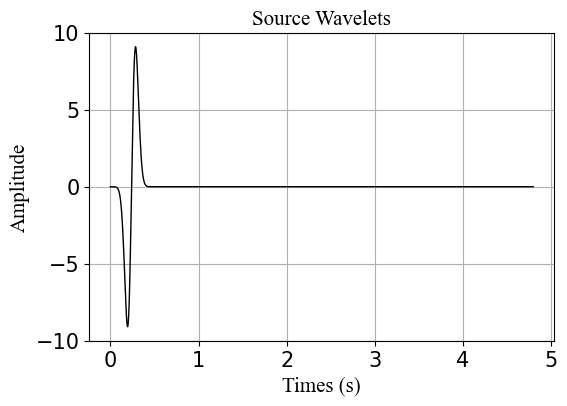

In [8]:
# Plot the wavelet used in the source
source.plot_wavelet(save_path=os.path.join(project_path, "survey/wavelets.png"))

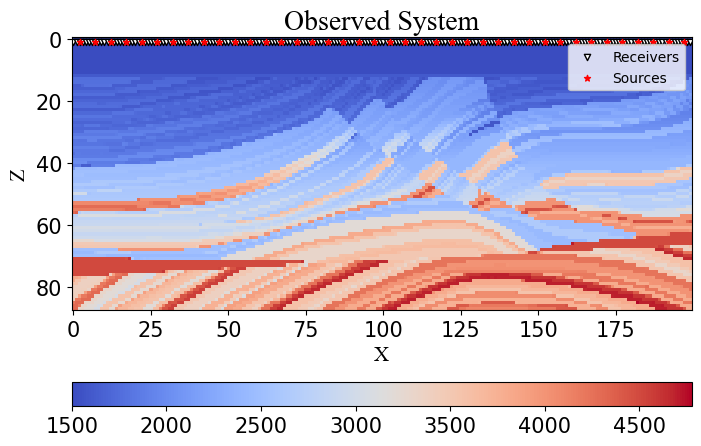

In [9]:
# Plot the survey configuration over the velocity model
survey.plot(model.vp, cmap='coolwarm', save_path=os.path.join(project_path, "survey/observed_system.png"))

## Define the propagator & Forward Modeling

In [10]:
# Initialize the wave propagator using the specified model and survey configuration
F = AcousticPropagator(model, survey, device=device)

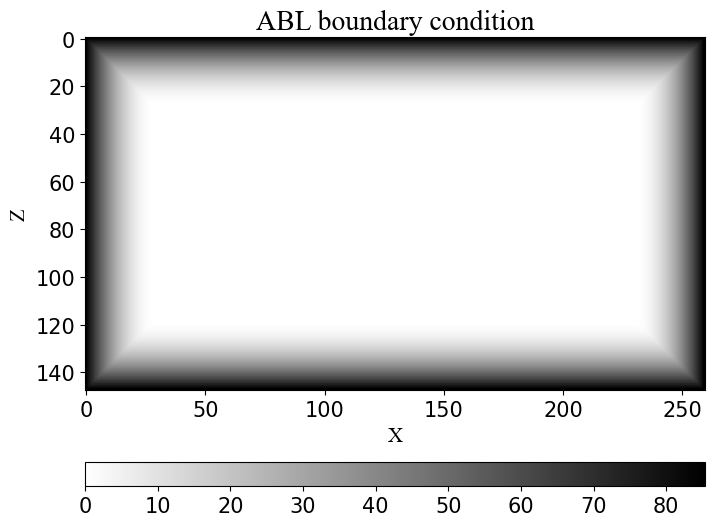

In [11]:
# Retrieve the damping array from the propagator and plot it to visualize boundary conditions
damp = F.damp
plot_damp(damp, save_path=os.path.join(project_path, "model/boundary_condition.png"))

In [12]:
# Perform the forward propagation to record waveforms
record_waveform = F.forward()

# Extract recorded pressure wavefield and particle velocities
rcv_p = record_waveform["p"]  # Recorded pressure wavefield
rcv_u = record_waveform["u"]  # Recorded particle velocity in x-direction
rcv_w = record_waveform["w"]  # Recorded particle velocity in z-direction

# Extract forward wavefields for analysis
forward_wavefield_p = record_waveform["forward_wavefield_p"]  # Forward pressure wavefield
forward_wavefield_u = record_waveform["forward_wavefield_u"]  # Forward particle velocity wavefield in x
forward_wavefield_w = record_waveform["forward_wavefield_w"]  # Forward particle velocity wavefield in z

In [13]:
# Create a SeismicData object to store observed data from the survey
d_obs = SeismicData(survey)

# Record the waveform data into the SeismicData object
d_obs.record_data(record_waveform)

# Save the recorded data to a specified file
d_obs.save(os.path.join(project_path, "waveform/obs_data_clean.npz"))

In [14]:
from ADFWI.utils.noise import add_gaussian_noise

noise_record_waveform = record_waveform.copy()
noise_level = np.std(noise_record_waveform["p"]) * 4
mean_bias_factor = 1
noise_record_waveform["p"] = add_gaussian_noise(noise_record_waveform["p"],std_noise=noise_level,mean_bias_factor=mean_bias_factor)
d_obs = SeismicData(survey)
d_obs.record_data(noise_record_waveform)
d_obs.save(os.path.join(project_path,"waveform/obs_data.npz"))

## Visulization the Synthetic Waveform

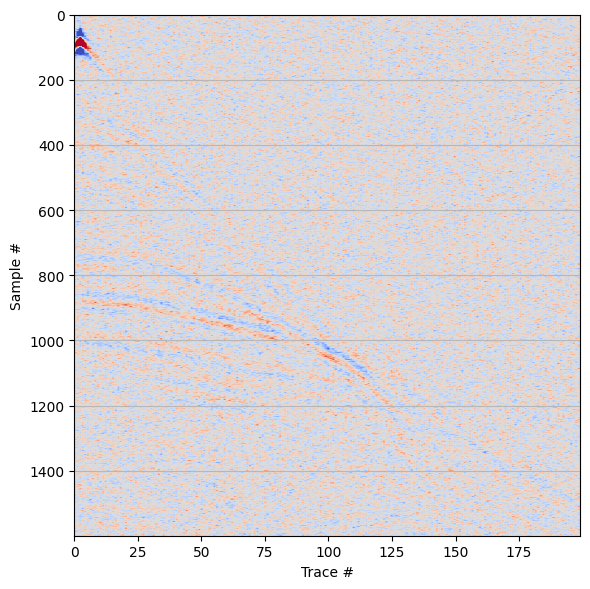

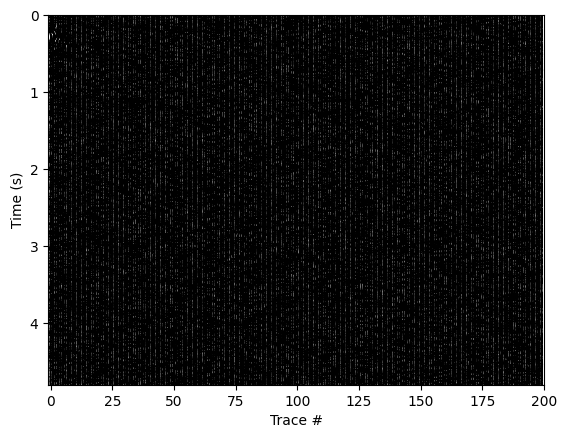

In [15]:
normalize = False  # Set normalization for waveform plotting

# Loop over shots to plot the observed waveforms
for i_shot in range(1):  # Currently set to plot only the first shot
    show = (i_shot == 0)  # Show the plot only for the first shot

    # Plot 2D waveform for the specified shot
    d_obs.plot_waveform2D(
        i_shot=i_shot,
        rcv_type="pressure",
        acoustic_or_elastic="acoustic",
        normalize=normalize,
        figsize=(6, 6),
        cmap='coolwarm',
        save_path=os.path.join(project_path, f"waveform/obs_2D_shot_{i_shot}.png"),
        show=show
    )

    # Plot wiggle representation of the waveform for the specified shot
    d_obs.plot_waveform_wiggle(
        i_shot=i_shot,
        rcv_type="pressure",
        acoustic_or_elastic="acoustic",
        normalize=normalize,
        save_path=os.path.join(project_path, f"waveform/obs_wiggle_shot_{i_shot}.png"),
        show=show
    )

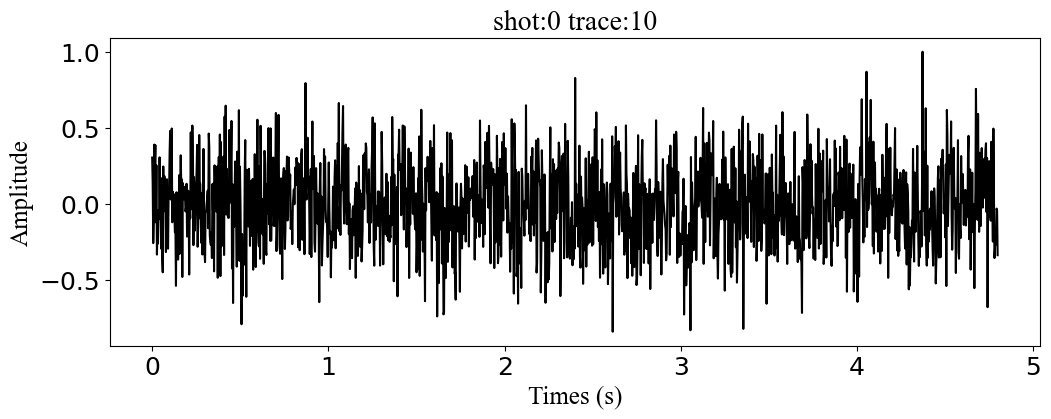

In [16]:
# Plot the waveform trace for a specific shot and trace index
d_obs.plot_waveform_trace(
    i_shot=0,  # Index of the shot to plot (first shot)
    i_trace=10,  # Index of the trace to plot (10th trace)
    normalize=True  # Normalize the waveform for better visualization
)